In [2]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tarfile
from netCDF4 import Dataset
import os

# Define the path to the tar.gz file and the extraction directory
tar_gz_path = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\example_output.tar.gz"
extraction_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)"

In [6]:
for root, _, files in os.walk(extraction_dir):
  for filename in files:
    if filename == "LIS_HIST_202401010000.d01.nc":
      filepath = os.path.join(root, filename)
      # Process the file here (e.g., open, read, analyze)
      print("Processing:", filepath)

Processing: D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\ROUTING\202401\LIS_HIST_202401010000.d01.nc
Processing: D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\SURFACEMODEL\202401\LIS_HIST_202401010000.d01.nc
Processing: D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\SURFACEMODEL\ROUTING\202401\LIS_HIST_202401010000.d01.nc
Processing: D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\SURFACEMODEL\SURFACEMODEL\202401\LIS_HIST_202401010000.d01.nc


In [4]:
# Directory containing the NetCDF files
data_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\SURFACEMODEL"
data_routing_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\ROUTING"

In [6]:
import os
import xarray as xr
# Function to recursively find all .nc files in a directory
def find_nc_files(directory):
    nc_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nc'):
                nc_files.append(os.path.join(root, file))
    return nc_files

In [8]:
# Find all .nc files in each directory
surface_files = find_nc_files(data_dir)
routing_files = find_nc_files(data_routing_dir)

# Check if files were found
print(f'Found {len(surface_files)} files in surfacemodel')
print(f'Found {len(routing_files)} files in routing')

# Load datasets
ds_surface = xr.open_mfdataset(surface_files, combine='by_coords')
ds_routing = xr.open_mfdataset(routing_files, combine='by_coords')

Found 15339 files in surfacemodel
Found 5113 files in routing


In [12]:
print(ds_surface)

<xarray.Dataset>
Dimensions:          (time: 5113, north_south: 36, east_west: 34,
                      SoilMoist_profiles: 4)
Coordinates:
  * time             (time) datetime64[ns] 2010-01-02 2010-01-03 ... 2024-01-01
Dimensions without coordinates: north_south, east_west, SoilMoist_profiles
Data variables:
    lat              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    lon              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    SoilMoist_tavg   (time, SoilMoist_profiles, north_south, east_west) float32 dask.array<chunksize=(1, 4, 36, 34), meta=np.ndarray>
    TWS_tavg         (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    Streamflow_tavg  (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNE

In [10]:
# Calculate the average soil moisture over a period

# Extract the soil moisture data
soil_moisture = ds_surface['SoilMoist_tavg']
TWS  = ds_surface['TWS_tavg']
STR  = ds_surface['Streamflow_tavg']

In [12]:
import pandas as pd
# Convert to DataFrames
soil_moisture_df = soil_moisture.to_dataframe().reset_index()
tws_df = TWS.to_dataframe().reset_index()
streamflow_df = STR.to_dataframe().reset_index()

# Merge DataFrames
merged_df = pd.merge(soil_moisture_df, tws_df, on=['time', 'north_south', 'east_west'])
merged_df = pd.merge(merged_df, streamflow_df, on=['time', 'north_south', 'east_west'])

# Calculate correlation coefficients
correlation_soil_moisture_tws = merged_df['SoilMoist_tavg'].corr(merged_df['TWS_tavg'])
correlation_soil_moisture_streamflow = merged_df['SoilMoist_tavg'].corr(merged_df['Streamflow_tavg'])
correlation_tws_streamflow = merged_df['TWS_tavg'].corr(merged_df['Streamflow_tavg'])

print('Correlation between Soil Moisture and TWS:', correlation_soil_moisture_tws)
print('Correlation between Soil Moisture and Streamflow:', correlation_soil_moisture_streamflow)
print('Correlation between TWS and Streamflow:', correlation_tws_streamflow)

Correlation between Soil Moisture and TWS: 0.887620691567946
Correlation between Soil Moisture and Streamflow: 0.14613450958037294
Correlation between TWS and Streamflow: 0.19191500184336022


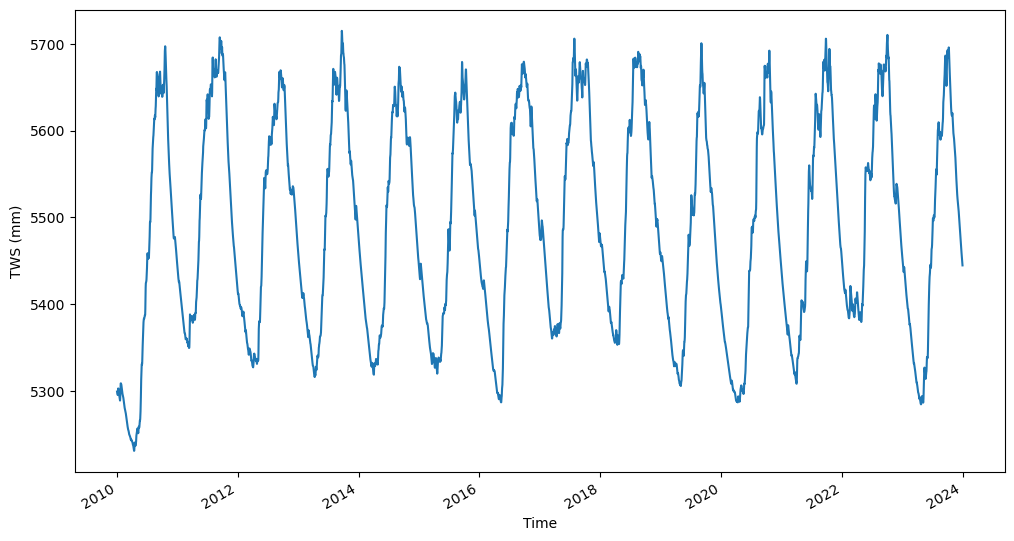

In [14]:
import matplotlib.pyplot as plt
# Calculate the mean TWS over the spatial dimensions
tws_mean = TWS.mean(dim=['north_south', 'east_west'])

# Plot the time series of mean TWS
tws_mean.plot(figsize=(12, 6))
plt.title=('Mean Terrestrial Water Storage Over Time')
plt.ylabel('TWS (mm)')
plt.xlabel('Time')

plt.savefig('Terrestrial_Water_Storage_Over_Time.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [18]:
tws_series = tws_mean.to_pandas()
print(tws_series)

time
2010-01-02    5299.439453
2010-01-03    5298.558594
2010-01-04    5297.517090
2010-01-05    5296.363770
2010-01-06    5295.453613
                 ...     
2023-12-28    5454.480469
2023-12-29    5451.945312
2023-12-30    5449.463867
2023-12-31    5447.118652
2024-01-01    5444.783203
Length: 5113, dtype: float32


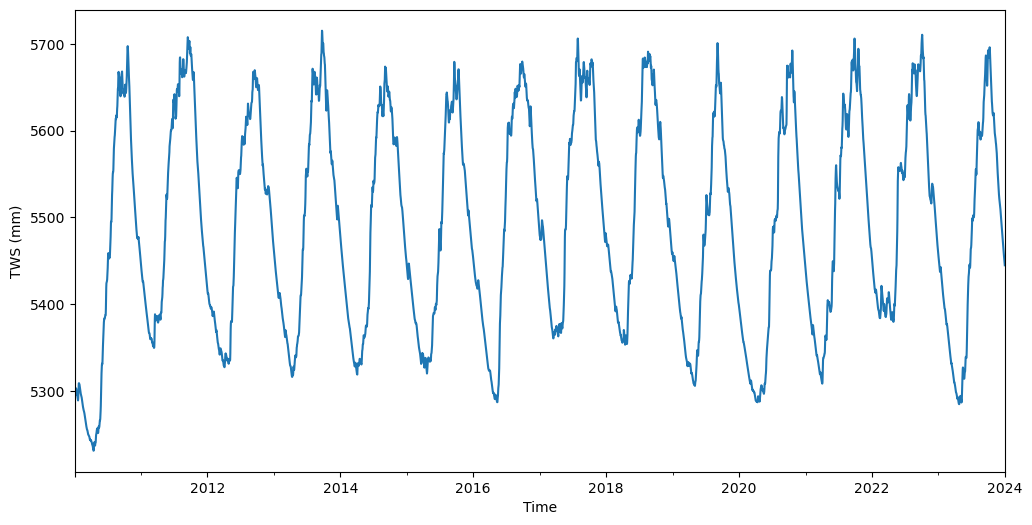

ADF Statistic: -6.955854304387079
p-value: 9.433460708503323e-10


In [22]:
from statsmodels.tsa.stattools import adfuller

# Plot the time series
tws_series.plot(figsize=(12, 6))
plt.ylabel('TWS (mm)')
plt.xlabel('Time')
#plt.title('Terrestrial Water Storage Over Time')
plt.show()

# Perform ADF test
adf_result = adfuller(tws_series)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


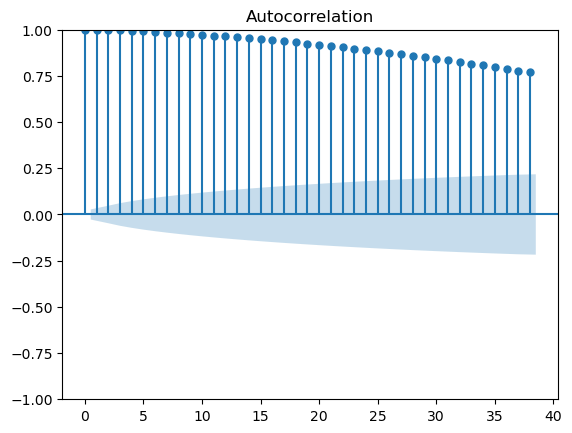

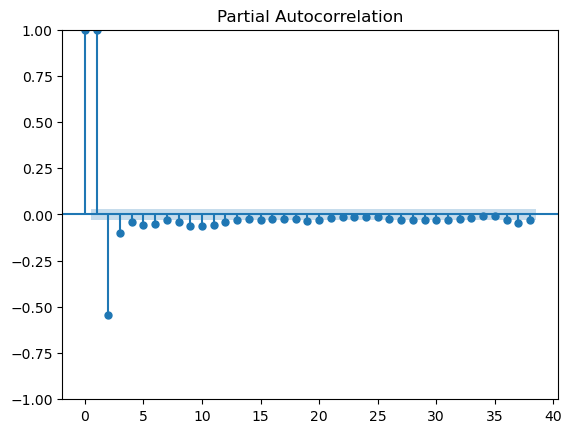

In [28]:
plot_acf(tws_series)
plot_pacf(tws_series)
plt.show()

In [32]:
# Fit the ARIMA model
model = ARIMA(tws_series, order=(1, 0, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5113
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -12049.400
Date:                Fri, 23 Aug 2024   AIC                          24106.800
Time:                        22:54:03   BIC                          24132.958
Sample:                    01-02-2010   HQIC                         24115.957
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5490.0748     72.123     76.121      0.000    5348.717    5631.433
ar.L1          0.9994      0.000   2107.227      0.000       0.998       1.000
ma.L1          0.7899      0.007    117.210      0.0

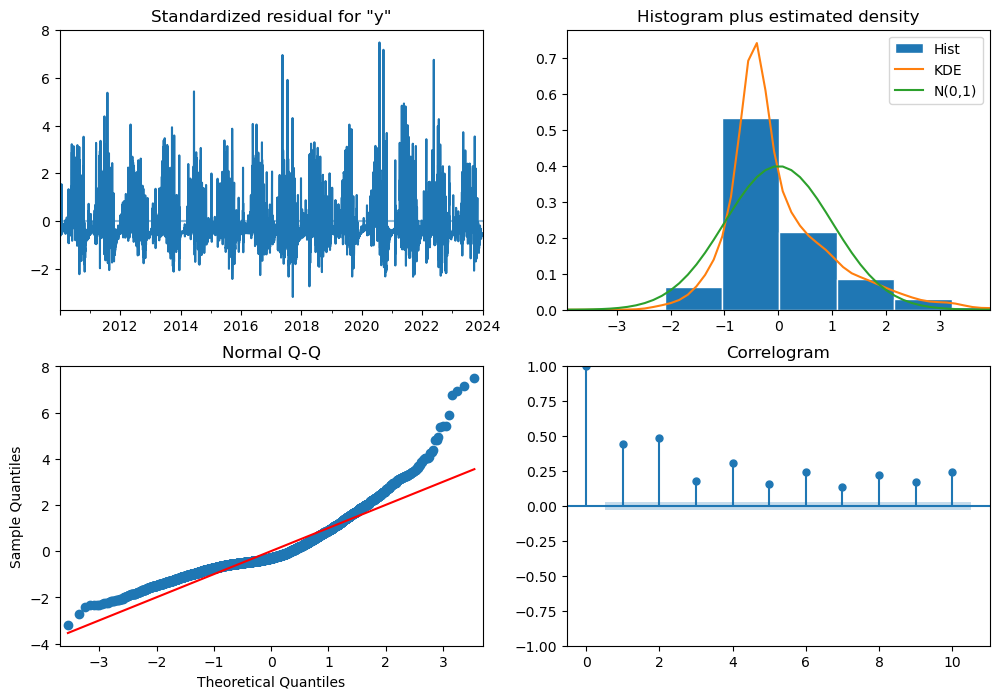

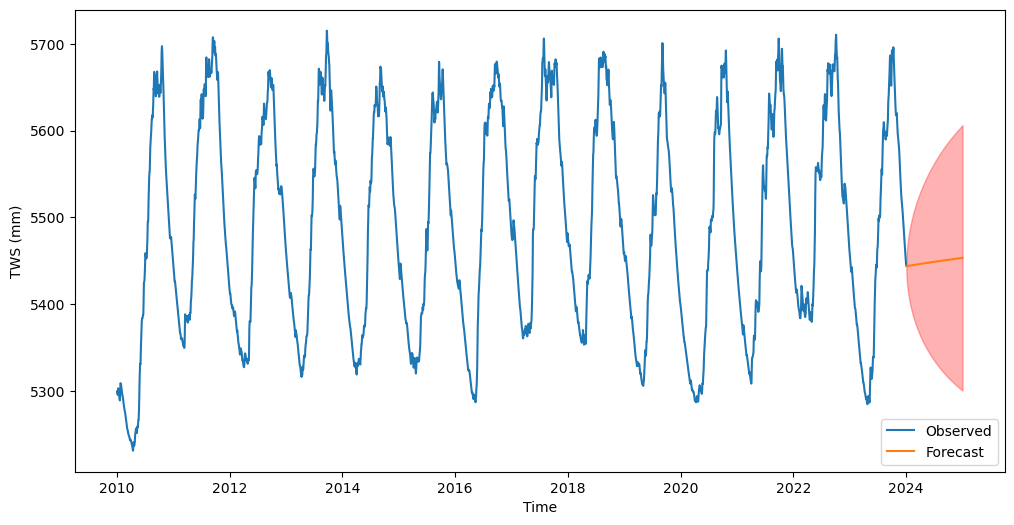

In [34]:
# Plot residuals
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecasting
forecast = model_fit.get_forecast(steps=365)  # Forecast for 1 year
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(tws_series, label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('TWS (mm)')
plt.legend()
plt.show()


In [46]:
pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
    --------------------------------------- 10.2/625.1 kB ? eta -:--:--
   ------------- -------------------------- 204.8/625.1 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------  624.6/625.1 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------- ------------------------------- 0.6/2.8 MB 19.8 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.8 MB 13.7 MB/s eta 0:00:01
   ------------------------------ --------- 2.2/2.8 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 14.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [48]:
import pmdarima as pm

# Use auto_arima to find the best (p, d, q) parameters
model = pm.auto_arima(
    tws_series,
    start_p=0, start_q=0,  # starting range for p and q
    max_p=5, max_q=5,      # maximum range for p and q
    seasonal=False,        # assuming no seasonality, set True if you have seasonal data
    d=None,                # let the model automatically determine the value of d
    trace=True,            # print status during fitting
    error_action='ignore', # ignore errors during fitting
    suppress_warnings=True,
    stepwise=True          # use stepwise search to reduce computation time
)

# Print the chosen parameters and model summary
print(model.summary())

# Fit the model with the selected parameters
model_fit = model.fit(tws_series)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=102568.438, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=24114.997, Time=1.35 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22630.482, Time=1.83 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=5.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=24111.634, Time=2.35 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=22255.525, Time=2.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=4.00 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=3.03 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=22170.658, Time=2.72 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=2.99 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=4.44 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=22128.924, Time=3.37 sec

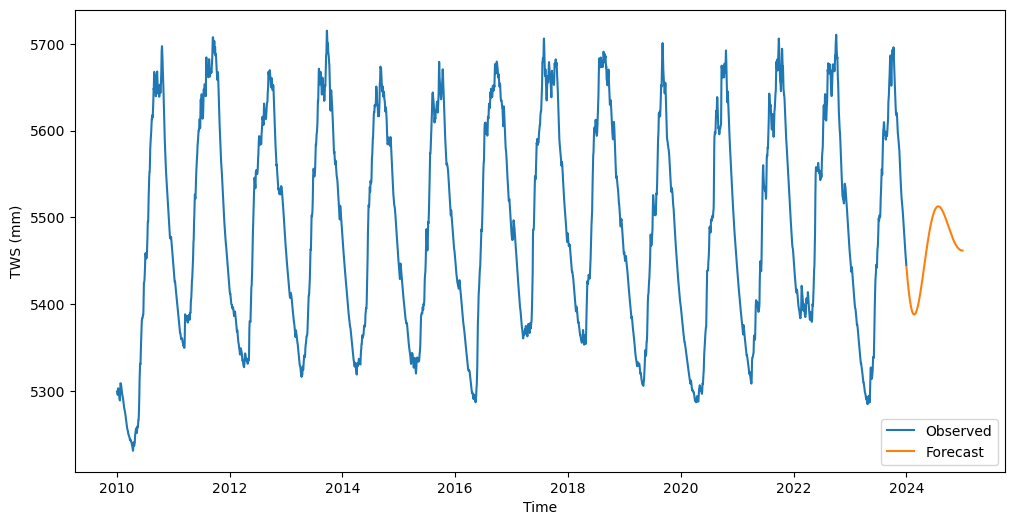

In [52]:
# Forecasting the next 365 days
forecast = model_fit.predict(n_periods=365)

# Convert to pandas DataFrame for easier plotting
forecast_index = pd.date_range(start=tws_series.index[-1], periods=365, freq='D')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tws_series, label='Observed')
plt.plot(forecast_series, label='Forecast')
plt.xlabel('Time')
plt.ylabel('TWS (mm)')
plt.legend()

plt.savefig('TWS_ARIMA_Forecast.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# Calculate the time mean and standard deviation
tws_mean = TWS.mean(dim='time')
tws_std = TWS.std(dim='time')

In [104]:
# Rechunk the time dimension to have a single chunk
tws_rechunked = TWS.chunk({'time': -1})

# Now apply the trend function across the spatial dimensions
tws_trend = xr.apply_ufunc(
    calc_trend, tws_rechunked, vectorize=True, 
    input_core_dims=[['time']], 
    dask='parallelized', 
    output_dtypes=[float]
)

In [106]:
# Calculate the trend
def calc_trend(data):
    time = np.arange(len(data))
    slope, intercept, r_value, p_value, std_err = linregress(time, data)
    return slope

In [88]:
pip install cartopy

     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     --------------------- ------------------ 30.7/56.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 56.0/56.0 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.2/10.9 MB 24.8 MB/s eta 0:00:01
   ---------------------- ----------------- 6.0/10.9 MB 64.2 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/10.9 MB 66.7 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/10.9 MB 66.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/10.9 MB 66.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/10.9 MB 66.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/10.9 MB 66.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/10.9 MB 66.8 MB/s eta 0:00:01
   ---------------------------------------- 10.9/10.9 MB 26.2 MB/s eta 0:0

C:\Users\ASUS\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\ASUS\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


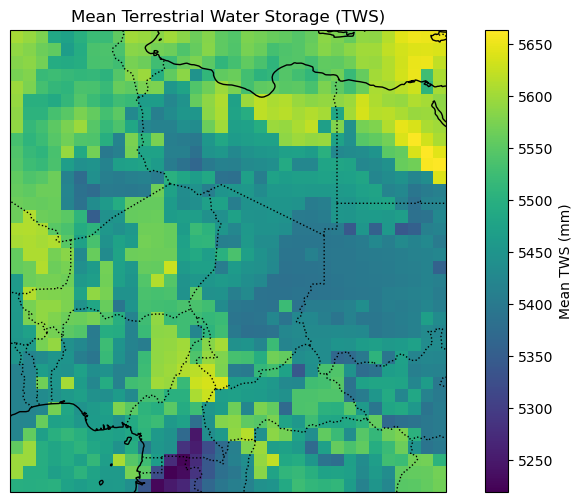

In [90]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress

# Define the map projection
#projection = ccrs.PlateCarree()


plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tws_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Mean TWS (mm)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Mean Terrestrial Water Storage (TWS)')
plt.show()

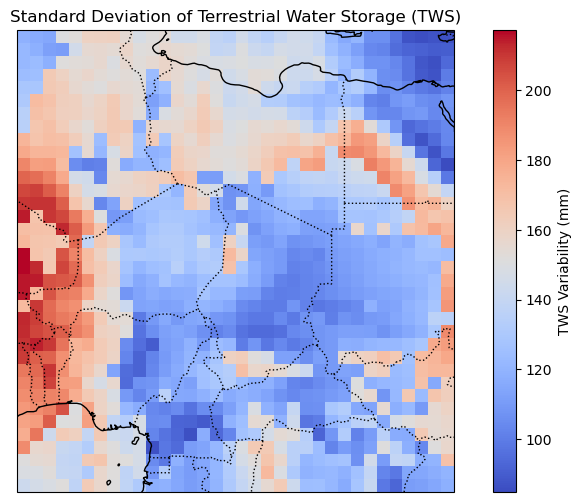

In [92]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tws_std.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'TWS Variability (mm)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Standard Deviation of Terrestrial Water Storage (TWS)')
plt.show()

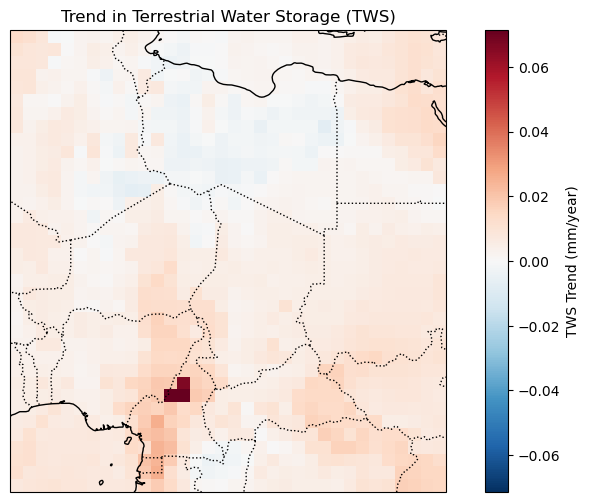

In [94]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tws_trend.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', cbar_kwargs={'label': 'TWS Trend (mm/year)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Trend in Terrestrial Water Storage (TWS)')
plt.show()

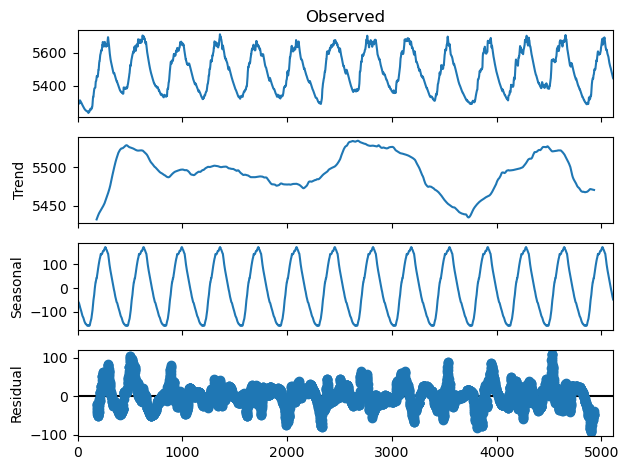

In [120]:
import statsmodels.api as sm

# Decompose the TWS time series at a specific location (e.g., mean over all locations)
tws_mean_over_space = TWS.mean(dim=['north_south', 'east_west'])
decomposition = sm.tsa.seasonal_decompose(tws_mean_over_space, model='additive', period=365)

# Plot the decomposition
decomposition.plot()
plt.show()


In [126]:
pip install esda

   ---------------------------------------- 0.0/135.4 kB ? eta -:--:--
   ----------- --------------------------- 41.0/135.4 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 135.4/135.4 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   --------------------------------------- 323.6/323.6 kB 20.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------  2.8/2.8 MB 59.7 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 59.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ----------- ---------------------------- 4.5/15.9 MB 145.3 MB/s eta 0:00:01
   ------------------ --------------------- 7.5/15.9 MB 95.7 MB/s eta 0:00:01
   ------------------------------------- -- 14.9/15.9 MB 162.4 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 131.1 MB/s eta 0:00:00
Note: yo

In [130]:
#Spatial Autocorrelation Analysis
import esda
from libpysal.weights import lat2W

# Assuming you have latitude and longitude arrays for each grid cell
w = lat2W(TWS.sizes['north_south'], TWS.sizes['east_west'])
moran = esda.moran.Moran(tws_mean.values.flatten(), w)

print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")

Moran's I: 0.7447902017621524
P-value: 0.001
